# CVNN Playground

The purpose of this notebook is to provide a simple playground for the Complex-Valued Neural Networks (CVNN) implementation, in the aim of proving their strengths vs real-valued neural networks. The CVNN is a neural network that uses complex numbers as input, output, and weights. The CVNN is implemented using PyTorch and the complextorch library.  
  
The notebook calls to a couple of other python files:  
- `cvnn_data.py` contains the data generation functions.  
- `cvnn_model.py` contains the CVNN model definitions.  

The notebook is divided into the following sections:
1. **Imports and settings** - Importing the necessary libraries and setting the data paths etc.
2. **Data Preparation** - Generating the data for the CVNN. By default this adds noise to the data, and randomly phase shifts the data by a random angle between -pi/4 and pi/4.
3. **Training loop definition**.
4. **Complex Valued Training** - Training `ComplexValuedNN` defined in `cvnn_models.py` on the generated data. This model uses two 1d complex convolutional layers with fully complex activation functions (Cardiod) and two fully connected layers.  
5. **Real Valued Training** - Training `RealValuedNN` defined in `cvnn_models.py` on the generated data. This model uses two 1d real convolutional layers (real and imag in a channel each) with ReLU activation functions and two fully connected layers.

### Results:  
It seems CVNNs can learn better with less neurons than RVNNs?  

Plot of the loss and accuracy of the CVNN and RVNN models during training:
![lossoutput_1m_pars.png](../cvnn_lossoutput_1m_pars.png)

## Imports and settings

In [1]:
import numpy as np
from numpy.fft import rfft, irfft
from functools import partial
rfft = partial(rfft, norm='ortho')
irfft = partial(irfft, norm='ortho')
import matplotlib.pyplot as plt

import torch
import torch
import torch.nn as nn
from torch.utils.data import Sampler
from typing import Iterator, Sized, List
from torch.utils.data import DataLoader
import torch
from cvnn_models import ComplexValuedNN, RealValuedNN
from cvnn_data import get_data, GlitchDataset

import matplotlib.pyplot as plt
import os
import random
from antiglitch import SnippetNormed

from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

In [2]:
# Torch setup

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}")
torch.backends.cuda.matmul.allow_tf32 = True

def memsum():
    print(torch.cuda.memory_summary(device=None, abbreviated=False))

Using device cuda


In [3]:
train_complex, test_complex = True, True
train_real, test_real = True, True
train_real_td, test_real_td = False, False

# define dataset
NTRAIN = 200000
NTEST = 50000

rootdir = '/home/xangma/OneDrive/repos/antiglitch/'
datadir = rootdir + 'data/'

np.random.seed(0)

## Data preparation

In [4]:
distributions, glitches, ifos, ml_models = get_data(datadir)

/home/xangma/OneDrive/repos/antiglitch/antiglitch/utils.py:29: RuntimeWarning: divide by zero encountered in power
  invasd = ((4096.*npz['psd'])**-0.5)[:4097]


In [5]:
train_data = GlitchDataset(datadir, ifos, ml_models, glitches, distributions, NTRAIN, NTEST, device, True, True, 'train', 'complex')
test_data = GlitchDataset(datadir, ifos, ml_models, glitches, distributions, NTRAIN, NTEST, device, True, True, 'test', 'complex')

# print max and mins of training and test data
print(f"Train data real + imag maxs: {torch.max(train_data.x_arr.real)}, {torch.max(train_data.x_arr.imag)}")
print(f"Test data real + imag maxs: {torch.max(test_data.x_arr.real)}, {torch.max(test_data.x_arr.imag)}")
print(f"Train data real + imag mins: {torch.min(train_data.x_arr.real)}, {torch.min(train_data.x_arr.imag)}")
print(f"Test data real + imag mins: {torch.min(test_data.x_arr.real)}, {torch.min(test_data.x_arr.imag)}")


tr_x_mean_real: -0.43476876616477966, tr_x_std_real: 95.09355163574219, tr_x_mean_imag: 0.005929230246692896, tr_x_std_imag: 87.00962829589844
tr_x_mean_real: -0.47817936539649963, tr_x_std_real: 95.45645904541016, tr_x_mean_imag: 0.018893592059612274, tr_x_std_imag: 86.6110610961914
te_x_mean_real: -0.3285030424594879, te_x_std_real: 97.0135269165039, te_x_mean_imag: -0.06745752692222595, te_x_std_imag: 87.17277526855469
Train data real + imag maxs: 420.0326843261719, 411.6373596191406
Test data real + imag maxs: 452.6535339355469, 228.2880859375
Train data real + imag mins: -396.6094055175781, -354.4373474121094
Test data real + imag mins: -302.5299987792969, -480.4379577636719


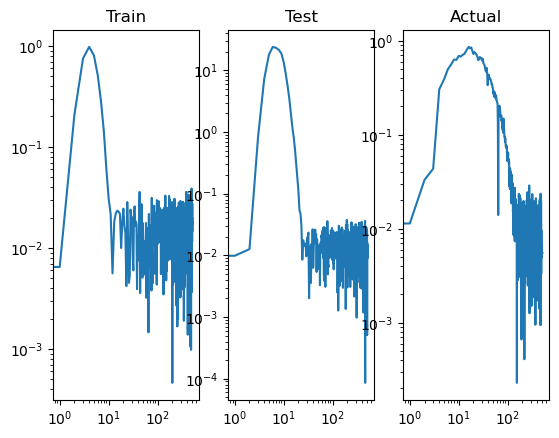

In [26]:
# Plot some data

trainitem = train_data.__getitem__(0)
testitem = test_data.__getitem__(0)
trainitem=trainitem[0].cpu().numpy()
testitem=testitem[0].cpu().numpy()

trainitem_td = irfft(trainitem)
testitem_td = irfft(testitem)
trainitem_td = np.roll(trainitem_td, 512)
testitem_td = np.roll(testitem_td, 512)

# Get a real snippet
ifo = np.random.choice(ifos)
ml_model = np.random.choice(ml_models)
glitch_num = random.choice(glitches[ifo][ml_model])
glitch_num = glitch_num['num']
# create a SnippetNormed object
snip = SnippetNormed(ifo, ml_model, glitch_num, datadir)
inf = {}
inf['freqs'] = np.linspace(0, 4096, 513)
snip.set_infer(inf)
# get the glitch data in the frequency domain
actual_item = rfft(snip.whts)
# scale it by the training scalings
actual_item_real = (actual_item.real - train_data.x_arr_mean_real) / train_data.x_arr_std_real
actual_item_imag = (actual_item.imag - train_data.x_arr_mean_imag) / train_data.x_arr_std_imag
actual_item = actual_item_real + 1j * actual_item_imag
actual_item = np.abs(actual_item)
# plot them all side by side
plt.figure()
plt.subplot(1,3,1)
plt.loglog(np.abs(trainitem))
plt.title('Train')
plt.subplot(1,3,2)
plt.loglog(np.abs(testitem))
plt.title('Test')
plt.subplot(1,3,3)
plt.loglog(actual_item)
plt.title('Actual')
plt.show()

In [23]:
class FastRandomSampler(Sampler[int]):
    def __init__(self, data_source: Sized, batch_size: int, generator=None) -> None:
        self.data_source = data_source
        self.data_len = len(self.data_source)
        self.batch_size = batch_size
        self.generator = generator or torch.Generator()
        self.epoch_indices = []
        self.set_epoch(0)  # Shuffle at initialization

    def _shuffle_indices(self):
        self.epoch_indices = torch.randperm(self.data_len, generator=self.generator).tolist()

    def __iter__(self) -> Iterator[List[int]]:
        # Yield batches of indices using slicing
        return (self.epoch_indices[i:i + self.batch_size] for i in range(0, self.data_len, self.batch_size))

    def __len__(self) -> int:
        # Number of batches in an epoch
        return (len(self.data_source) + self.batch_size - 1) // self.batch_size
    
    def set_epoch(self, epoch: int) -> None:
        self._shuffle_indices()  # Shuffle indices for the new epoch

In [9]:
# Load into DataLoader
tr_sampler = FastRandomSampler(train_data, 1024)
te_sampler = FastRandomSampler(test_data, 1024)
collate_fn = lambda x: tuple(x)
train_loader = DataLoader(dataset=train_data, sampler=tr_sampler,   drop_last=False)
test_loader = DataLoader(dataset=test_data, sampler=te_sampler,   drop_last=False)
list(train_loader.__iter__())[0][0].shape

torch.Size([1, 1024, 513])

## Training Loop Definition

In [10]:
# Training loop
def train(model, criterion, optimizer, scheduler, train_loader, test_loader, num_epochs, model_path, writer):
    epoch_count=0
    # Load model if it exists
    try:
        # find model with highest epoch number
        model_files = os.listdir(model_path)
        model_files = [f for f in model_files if f.endswith('.pt')] 
        if len(model_files) > 0:
            model_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
            model_path = model_path + model_files[-1]
            print(f'Loading model {model_path}')
            model.load_state_dict(torch.load(model_path))
            print('Model loaded')
            epoch_count = int(model_path.split('_')[-1].split('.')[0])
    except:
        print('Model not loaded')
    torch.autograd.set_detect_anomaly(True)
    loss_arr = []
    val_loss_arr = []
    while epoch_count < num_epochs:
        model.train()
        total_training_loss = 0
        for i, data in enumerate(train_loader):
            inputs, targets = data
            # Forward pass
            outputs = model(inputs[0])
            loss = criterion(outputs, targets[0])
            total_training_loss += loss.item()
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_arr.append(total_training_loss/len(train_loader))

        # Test the model
        model.eval()
        with torch.no_grad():
            total_loss = 0
            for i, data in enumerate(test_loader):
                inputs, targets = data
                outputs = model(inputs[0])
                val_loss = criterion(outputs, targets[0]).item()
                total_loss += val_loss
            val_loss_arr.append(total_loss/len(test_loader))
        print(f"Epoch [{epoch_count+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {total_loss/len(test_loader):.4f}")
        
        # update the learning rate
        scheduler.step(total_loss/len(test_loader))

        train_loader.sampler.set_epoch(epoch_count)
        epoch_count += 1
        
        writer.add_scalars("Loss", {"Train": total_training_loss/len(train_loader), "Validation": total_loss/len(test_loader)}, epoch_count)
        writer.add_scalar("Learning rate", optimizer.param_groups[0]['lr'], epoch_count)
        
        # save the model every 10 epochs
        if epoch_count % 10 == 0 and epoch_count != 0:
            torch.save(model.state_dict(), model_path.split('.')[0] + f'_{epoch_count}.pt')
        writer.flush()
    return loss_arr, val_loss_arr
            


## Complex Valued Training

In [11]:
if train_complex:
    if any([x in locals() for x in ['model', 'criterion', 'optimizer', 'scheduler', 'writer']]):
        del model, criterion, optimizer, scheduler, writer
        torch.cuda.empty_cache()
    # Create an instance of the network
    model = ComplexValuedNN()

    # put model on device
    model.to(device)

    model = torch.compile(model)
    # Print the model architecture
    print(model)
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20, verbose=True)
    writer = SummaryWriter("Complex_valued")
    model_path = rootdir + 'notebooks/complex_nn_model.pt'

/home/xangma/miniconda3/envs/antiglitch/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


OptimizedModule(
  (_orig_mod): ComplexValuedNN(
    (conv1): CVConv1d(
      (conv_r): Conv1d(1, 4, kernel_size=(1,), stride=(1,), padding=same)
      (conv_i): Conv1d(1, 4, kernel_size=(1,), stride=(1,), padding=same)
    )
    (activation1): CVSigLog()
    (bn1): CVBatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): CVConv1d(
      (conv_r): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=same)
      (conv_i): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=same)
    )
    (activation2): CVSigLog()
    (bn2): CVBatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): CVLinear(
      (linear_r): Linear(in_features=4104, out_features=128, bias=False)
      (linear_i): Linear(in_features=4104, out_features=128, bias=False)
    )
    (activation3): CVSigLog()
    (fc3): CVLinear(
      (linear_r): Linear(in_features=128, out_features=32, bias=False)
      (linear_i): Linear(in_features=128, out_features=32,

/home/xangma/miniconda3/envs/antiglitch/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [12]:
torch.cuda.empty_cache()
if train_complex:
    complex_train_loss_arr,  complex_val_loss_arr = train(model, criterion, optimizer, scheduler, train_loader, test_loader, 200, model_path, writer)
    # save the loss arrays into a single file
    np.savez(rootdir + 'notebooks/complex_loss_arrays.npz', train=complex_train_loss_arr, val=complex_val_loss_arr)
    del model, criterion, optimizer, scheduler, writer
    torch.cuda.empty_cache()
    memsum()

Model not loaded


/home/xangma/miniconda3/envs/antiglitch/lib/python3.11/site-packages/torch/_inductor/lowering.py:1778: UserWarning: Torchinductor does not support code generation for complex operators. Performance may be worse than eager.
  warnings.warn(


Epoch [1/200], Training Loss: 0.6021, Validation Loss: 0.8167
Epoch [2/200], Training Loss: 0.6214, Validation Loss: 0.7330
Epoch [3/200], Training Loss: 0.5385, Validation Loss: 0.6833
Epoch [4/200], Training Loss: 0.5199, Validation Loss: 0.6458
Epoch [5/200], Training Loss: 0.5763, Validation Loss: 0.6165
Epoch [6/200], Training Loss: 0.5869, Validation Loss: 0.5921
Epoch [7/200], Training Loss: 0.7769, Validation Loss: 0.5718
Epoch [8/200], Training Loss: 0.5607, Validation Loss: 0.5525
Epoch [9/200], Training Loss: 0.5131, Validation Loss: 0.5362
Epoch [10/200], Training Loss: 0.4498, Validation Loss: 0.5193
Epoch [11/200], Training Loss: 0.5007, Validation Loss: 0.5055
Epoch [12/200], Training Loss: 0.5882, Validation Loss: 0.4920
Epoch [13/200], Training Loss: 0.3553, Validation Loss: 0.4794
Epoch [14/200], Training Loss: 0.3964, Validation Loss: 0.4648
Epoch [15/200], Training Loss: 0.4237, Validation Loss: 0.4531
Epoch [16/200], Training Loss: 0.4377, Validation Loss: 0.4406
E

In [14]:
if test_complex:
    # Predictions from Complex model
    # Load model
    model = ComplexValuedNN()
    model = torch.compile(model)
    model.load_state_dict(torch.load(model_path.split('.')[0] + '_200.pt'))
    model.to(device)
    model.eval()


In [15]:
if test_complex:
    # Get 10 inputs
    inputs, targets = next(iter(test_loader))
    outputs = model(inputs[0])

    if type(outputs) == torch.Tensor:
        outputs = outputs.cpu().detach().numpy()
    if type(targets) == torch.Tensor:
        targets = targets[0].cpu().detach().numpy()
    for i in range(0,10):
        print(f"Prediction: {outputs[i]}")
        print(f"Target: {targets[i]}")
        print("\n")
    del model, inputs, targets, outputs
    torch.cuda.empty_cache()

Prediction: [2.9603562  0.02432579]
Target: [ 0.3724822 -0.7465734]


Prediction: [-0.32014582  2.5385983 ]
Target: [-0.4032861  2.6188056]


Prediction: [-0.23523828  0.905072  ]
Target: [0.07039674 0.7326371 ]


Prediction: [ 0.5234614 -0.8047174]
Target: [ 0.9033805 -0.7431447]


Prediction: [ 1.7327452  -0.28164253]
Target: [ 1.3933632 -0.7291103]


Prediction: [-0.47473684 -0.4513449 ]
Target: [-0.46513036 -0.39182633]


Prediction: [-0.2525702  0.8171274]
Target: [-0.01738029  0.88171947]


Prediction: [ 2.0418417  -0.45251694]
Target: [ 1.8529413 -0.4212125]


Prediction: [ 0.351755   -0.44346517]
Target: [ 0.66254276 -0.5259549 ]


Prediction: [-0.5968554  -0.34974566]
Target: [-0.4233048  -0.17582156]




# Real Valued Training

In [16]:
if train_real:
    # Create an instance of the network
    model = RealValuedNN()

    # put model on device
    model.to(device)
    model = torch.compile(model)

    # Print the model architecture
    print(model)
    print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20, verbose=True)
    writer = SummaryWriter("Real_valued")
    model_path = rootdir + 'notebooks/real_nn_model.pt'

OptimizedModule(
  (_orig_mod): RealValuedNN(
    (conv1): Conv1d(2, 8, kernel_size=(1,), stride=(1,), padding=same)
    (activation1): ReLU()
    (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=same)
    (activation2): ReLU()
    (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=8208, out_features=128, bias=True)
    (activation3): ReLU()
    (fc2): Linear(in_features=128, out_features=32, bias=True)
    (activation4): ReLU()
    (output_layer): Linear(in_features=32, out_features=2, bias=True)
  )
)
Number of parameters: 1055418


/home/xangma/miniconda3/envs/antiglitch/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [17]:
# Training loop
if train_real:
    real_train_loss_arr,  real_val_loss_arr = train(model, criterion, optimizer, scheduler, train_loader, test_loader, 200, model_path, writer)
    # save the loss arrays into a single file
    np.savez(rootdir + 'notebooks/real_loss_arrays.npz', train=real_train_loss_arr, val=real_val_loss_arr)
    del model, criterion, optimizer, scheduler, writer
    torch.cuda.empty_cache()
    memsum()

Model not loaded
Epoch [1/200], Training Loss: 0.5640, Validation Loss: 0.8390
Epoch [2/200], Training Loss: 0.5983, Validation Loss: 0.7482
Epoch [3/200], Training Loss: 0.7477, Validation Loss: 0.6880
Epoch [4/200], Training Loss: 0.5072, Validation Loss: 0.6304
Epoch [5/200], Training Loss: 0.3996, Validation Loss: 0.5995
Epoch [6/200], Training Loss: 0.5652, Validation Loss: 0.5680
Epoch [7/200], Training Loss: 0.4639, Validation Loss: 0.5213
Epoch [8/200], Training Loss: 0.5455, Validation Loss: 0.4979
Epoch [9/200], Training Loss: 0.4737, Validation Loss: 0.4817
Epoch [10/200], Training Loss: 0.4080, Validation Loss: 0.4600
Epoch [11/200], Training Loss: 0.4254, Validation Loss: 0.4388
Epoch [12/200], Training Loss: 0.4366, Validation Loss: 0.4297
Epoch [13/200], Training Loss: 0.2702, Validation Loss: 0.4030
Epoch [14/200], Training Loss: 0.3095, Validation Loss: 0.3956
Epoch [15/200], Training Loss: 0.4149, Validation Loss: 0.3787
Epoch [16/200], Training Loss: 0.2726, Validati

In [20]:
if test_real:
    # Predictions from Real model
    # Load model
    model = RealValuedNN()
    model = torch.compile(model)
    model.load_state_dict(torch.load(model_path.split('.')[0] + '_200.pt'))
    
    model.to(device)
    model.eval()


In [21]:
if test_real:
    # Get 10 inputs
    inputs, targets = next(iter(test_loader))
    outputs = model(inputs[0])

    if type(outputs) == torch.Tensor:
        outputs = outputs.cpu().detach().numpy()
    if type(targets) == torch.Tensor:
        targets = targets[0].cpu().detach().numpy()
    for i in range(0,10):
        print(f"Prediction: {outputs[i]}")
        print(f"Target: {targets[i]}")
        print("\n")
    del model, inputs, targets, outputs
    torch.cuda.empty_cache()

Prediction: [0.6634221  0.21731375]
Target: [ 0.3724822 -0.7465734]


Prediction: [-0.31282282  3.389388  ]
Target: [-0.4032861  2.6188056]


Prediction: [0.18463475 1.0332322 ]
Target: [0.07039674 0.7326371 ]


Prediction: [ 0.4181675  -0.86073047]
Target: [ 0.9033805 -0.7431447]


Prediction: [ 0.69401145 -0.48989454]
Target: [ 1.3933632 -0.7291103]


Prediction: [-0.4020033  -0.23055655]
Target: [-0.46513036 -0.39182633]


Prediction: [0.03146328 0.81632197]
Target: [-0.01738029  0.88171947]


Prediction: [ 2.2611365  -0.31501734]
Target: [ 1.8529413 -0.4212125]


Prediction: [ 0.05451441 -0.02576794]
Target: [ 0.66254276 -0.5259549 ]


Prediction: [-0.44485116 -0.13272715]
Target: [-0.4233048  -0.17582156]




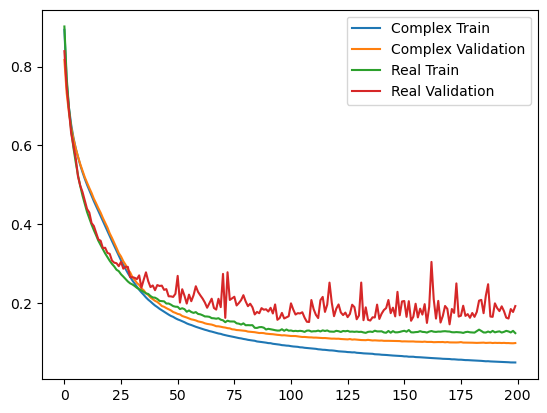

In [19]:
# Load any existing complex and real loss arrays
if 'complex_train_loss_arr' not in locals():
    complex_loss_arrays = np.load(rootdir + 'notebooks/complex_loss_arrays.npz')
    complex_train_loss_arr = complex_loss_arrays['train']
    complex_val_loss_arr = complex_loss_arrays['val']
if 'real_train_loss_arr' not in locals():
    real_loss_arrays = np.load(rootdir + 'notebooks/real_loss_arrays.npz')
    real_train_loss_arr = real_loss_arrays['train']
    real_val_loss_arr = real_loss_arrays['val']

# Plot the loss arrays
plt.figure()
plt.plot(complex_train_loss_arr, label='Complex Train')
plt.plot(complex_val_loss_arr, label='Complex Validation')
plt.plot(real_train_loss_arr, label='Real Train')
plt.plot(real_val_loss_arr, label='Real Validation')
plt.legend()
plt.show()


## Real Valued in the time domain ( DEV/UNTESTED CODE BELOW )

## Recreate the dataset

In [ ]:
# del train_data, test_data, train_loader, test_loader
# torch.cuda.empty_cache()

train_data = GlitchDataset(datadir, ifos, ml_models, glitches, distributions, NTRAIN, NTEST, device, True, 'train', 'real')
test_data = GlitchDataset(datadir, ifos, ml_models, glitches, distributions, NTRAIN, NTEST, device, True, 'test', 'real')
tr_sampler = FastRandomSampler(train_data, 1024)
te_sampler = FastRandomSampler(test_data, 1024)

train_loader = DataLoader(dataset=train_data,sampler = tr_sampler,  drop_last=False)
test_loader = DataLoader(dataset=test_data, sampler = te_sampler, drop_last=False)
# testitem = test_data.__getitem__(0)
# print(testitem[0][1:20], testitem[1])

tr_x_mean_real: 0.0027130309026688337, tr_x_std_real: 91.55573272705078, tr_x_mean_imag: 0.04036274552345276, tr_x_std_imag: 90.72611999511719
tr_x_mean_real: -0.03800196573138237, tr_x_std_real: 91.67253112792969, tr_x_mean_imag: -0.031019236892461777, tr_x_std_imag: 90.60796356201172


In [ ]:
from antiglitch import SnippetNormed
trainitem = train_data.__getitem__(np.random.randint(0, NTRAIN))
testitem = test_data.__getitem__(np.random.randint(0, NTEST))

# Get a real snippet
ifo = np.random.choice(ifos)
ml_model = np.random.choice(ml_models)
glitch_num = random.choice(glitches[ifo][ml_model])
glitch_num = glitch_num['num']
# create a SnippetNormed object
snip = SnippetNormed(ifo, ml_model, glitch_num, datadir)
inf = {}
inf['freqs'] = np.linspace(0, 4096, 513)
snip.set_infer(inf)
# get the glitch data in the time domain
actual_item = snip.whts
# scale it by the training scalings
actual_item = (actual_item - train_data.x_arr_mean) / train_data.x_arr_std
# plot them all side by side
plt.figure()
plt.subplot(1,3,1)
plt.plot(trainitem[0].cpu().numpy())
plt.title('Train')
plt.subplot(1,3,2)
plt.plot(testitem[0].cpu().numpy())
plt.title('Test')
plt.subplot(1,3,3)
plt.plot(actual_item)
plt.title('Actual')
plt.show()


/home/xangma/OneDrive/repos/antiglitch/antiglitch/utils.py:29: RuntimeWarning: divide by zero encountered in power
  invasd = ((4096.*npz['psd'])**-0.5)[:4097]


AttributeError: 'GlitchDataset' object has no attribute 'x_arr_mean'

: 

In [ ]:
# Real Valued Training
input_dim = 513  # Number of input features
output_dim = 2  # Number of output units (as specified in the dataset)
# reimport the real valued model from cvnn_models
from cvnn_models import RealValuedNNtd

# Create an instance of the network
model = RealValuedNNtd()

# put model on device
model.to(device)

# Print the model architecture
print(model)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")


In [ ]:

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20, verbose=True)
writer = SummaryWriter("Real_valued_td")
model_path = rootdir + 'notebooks/real_td_nn_model.pth'


In [ ]:
# Training loop
if train_real_td:
    train(model, criterion, optimizer, scheduler, train_loader, test_loader, 100, model_path, writer)


In [ ]:
(1024*16384)-(65536*256)

In [ ]:

del model, criterion, optimizer, scheduler, writer
torch.cuda.empty_cache()
memsum()


In [ ]:

if test_real_td:
    # Predictions from Real model
    # Load model
    model = RealValuedNN()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()


In [ ]:

if test_real_td:
    # Get 10 inputs
    inputs, targets = next(iter(test_loader))
    outputs = model(inputs[0].real, inputs[0].imag)

    if type(outputs) == torch.Tensor:
        outputs = outputs.cpu().detach().numpy()
    if type(targets) == torch.Tensor:
        targets = targets[0].cpu().detach().numpy()
    for i in range(0,10):
        print(f"Prediction: {outputs[i]}")
        print(f"Target: {targets[i]}")
        print("\n")
del model, inputs, targets, outputs
torch.cuda.empty_cache()